In [ ]:
!pip install keras numpy wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=16057f2bd1236e93e1dfd1b5c4f1d22710f6e30e967a52cd7abab5dafda336b8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import io
import sys
import pandas as pd

In [ ]:
def load_corpus(path):

  relations = ["Cause-Effect", "Component-Whole", "Entity-Destination", "Entity-Origin", "Other-Relation"]
  other = "Other-Relation"
  with open(path, 'r') as f: 
    data = f.readlines()
    # Every 4 lines is one chunk
    # 2nd line is the relation 
    return data


trainingData = load_corpus('/content/drive/My Drive/TRAIN_FILE.TXT')

In [ ]:
def replaceRelations(data):
  filteredData = [d.replace("Other", "Other-Relation").replace("Member-Collection", "Other-Relation").replace("Product-Producer", "Other-Relation")
  .replace("Content-Container", "Other-Relation")
  .replace("Message-Topic", "Other-Relation").replace("Instrument-Agency", "Other-Relation") for d in data]
  print(filteredData[8])
  print(filteredData[9])
  print(filteredData[10])
  print(filteredData[11])
  return filteredData

filteredData = replaceRelations(trainingData)


3	"The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code."

Other-Relation(e2,e1)

Comment:





In [ ]:
def removeComments(filteredData):

  noEntity = filteredData[::2]
  noComment = noEntity[::2]

  return noComment

noComment = removeComments(filteredData)


In [ ]:
import re

def datasetStats(filteredData, noComment):
  otherRelation = re.compile("Other-Relation*")
  causeEffect = re.compile("Cause-Effect*")
  componentWhole = re.compile("Component-Whole*")
  entityDestination = re.compile("Entity-Destination*")
  entityOrigin = re.compile("Entity-Origin*")

  otherRelationSum = sum(1 for x in filteredData if otherRelation.match(x))
  causeEffectSum = sum(1 for x in filteredData if causeEffect.match(x))
  componentWholeSum = sum(1 for x in filteredData if componentWhole.match(x))
  entityDestination = sum(1 for x in filteredData if entityDestination.match(x))
  entityOrigin = sum(1 for x in filteredData if entityOrigin.match(x))

  totalSentences = len(noComment)

  otherRelationPercent = "{:.2f}".format(otherRelationSum/totalSentences * 100)
  causeEffectPercent = "{:.2f}".format(causeEffectSum/totalSentences * 100)
  componentWholePercent = "{:.2f}".format(componentWholeSum/totalSentences * 100)
  entityDestinationPercent = "{:.2f}".format(entityDestination/totalSentences * 100)
  entityOriginPercent = "{:.2f}".format(entityOrigin/totalSentences * 100)

  print("Dataset Statistics")
  print("Total sentences", totalSentences)
  print("Other-Relation - ", otherRelationSum, "("+ otherRelationPercent + "%"+")")
  print("Cause-Effect - ", causeEffectSum, "("+ causeEffectPercent + "%"+")")
  print("Component-Whole - ", componentWholeSum, "("+ componentWholePercent +"%"+")")
  print("Entity-Destination - ", entityDestination, "("+entityDestinationPercent +"%"+")")
  print("Entity-Origin - ", entityOrigin, "("+entityOriginPercent + "%"+")")


# Cause-Effect, Component-Whole, Entity-Destination,
# Entity-Origin, and Other-Relation
datasetStats(filteredData, noComment)


Dataset Statistics
Total sentences 8000
Other-Relation -  4495 (56.19%)
Cause-Effect -  1003 (12.54%)
Component-Whole -  941 (11.76%)
Entity-Destination -  845 (10.56%)
Entity-Origin -  716 (8.95%)


In [ ]:
def cleanComments(filteredData):
  jk = [x for x in filteredData if not x.startswith("Comment") and len(x) > 1]
  return jk

jk = cleanComments(filteredData)

In [ ]:

import string
from string import digits
import re
def cleanSentences(noComment):
  lines = []
  for d in noComment:
    noTabs = re.sub('\s+',' ', d)
    # elems = noTabs.replace("<e1>", " _e1_ ").replace("</e1>", " _e1_ ").replace("<e2>", " _e2_ ").replace("</e2>", " _e2_ ")
    # noNums = noTabs.translate(str.maketrans('', '', digits))
    lines.append(noTabs)
  return lines
  # print(lines[1:5])

lines = cleanSentences(noComment)

In [ ]:
import string
from string import digits

def maxLength(sentences):
  # print(len(sentences[0]))
  return max(len(d) for d in sentences)

def removeTokens(lines):
  sentences = []
  maxLen = maxLength(lines)
  for sent in lines:
    filteredElem = sent.replace("<e1>", "<eO>").replace("</e1>", "").replace("<e2>", "<eT>").replace("</e2>", "").strip()
    noNums = filteredElem.translate(str.maketrans('', '', digits))
    sentence = noNums.split(" ")
    sentence = [w for w in sentence if len(w) > 1]
    line = " ".join(sentence)
    sentences.append(line)
  
  return sentences

sentences = removeTokens(lines)
  
  # break
# print(sentences)




In [ ]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(sentences):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(sentences)
	return tokenizer



 

tokenizer = create_tokenizer(sentences)
vocabSize = len(tokenizer.word_index) + 1
print(vocabSize)
maxSentenceLength = maxLength(sentences)
print(maxSentenceLength)

19144
498


In [ ]:
def get_relative_position(sentences, max_sentence_length):
    # Position data
    firstToken = []
    secondToken = []
    words = []
    for sent in sentences:
      sent = sent.split(" ")
      pos1 = [0 for x in range(len(sent))]
      pos2 = [0 for x in range(len(sent))]
      token1 = [i for i, s in enumerate(sent) if '<eO>' in s]
      token2 = [i for i, s in enumerate(sent) if '<eT>' in s]
      sentenceLen = len(sent)
      for i in range(sentenceLen):
        pos1[i] = max_sentence_length +  (i - token1[0])
        pos2[i] = max_sentence_length +  (i - token2[0])
      firstToken.append(pos1)
      secondToken.append(pos2)
      line = " ".join(sent).replace("<eO>", "").replace("<eT>", "")
      words.append(line)

    return words, firstToken, secondToken


words, firstToken, secondToken = get_relative_position(sentences, maxSentenceLength)

In [ ]:
import pandas as pd

def createDF(labelData, words, firstToken, secondToken):
  # b = jk[::2]
  entityLables = labelData[1::2]
  # labels = []
  pattern = r'\([^)]*\)'
  entitySet = [re.sub(r'\([^)]*\)', '', x.strip()) for x in entityLables]
  # print(len(entitySet))


  dataTuples = list(zip(words,entitySet,firstToken,secondToken))
  df = pd.DataFrame(dataTuples, columns=['sentences','labels','firstToken', 'secondToken'])
  df.head(n=10)
  # print(len(dataTuples))
  return df

df = createDF(jk, words, firstToken, secondToken)




In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def getTokenizer(df):
  # vocabulary size
  n_most_common_words = 20000
  # Initialization
  tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True, oov_token='-1')
  # Fit and transformation
  tokenizer.fit_on_texts(df['sentences'].values)
  return tokenizer

def getSequences(tokenizer, lines):
  sequences = tokenizer.texts_to_sequences(lines)
  # print("seq", sequences)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  return sequences

def padX(sequences):
  # Padding
  # print(word_index)
  X = pad_sequences(sequences, maxlen=maxSentenceLength)
  return X 

trainedTokenizer = getTokenizer(df)
sequencesX = getSequences(trainedTokenizer, lines)
X = padX(sequencesX)

Found 19150 unique tokens.


In [ ]:
X_pos1 = pad_sequences(firstToken, maxlen=maxSentenceLength)
X_pos2 = pad_sequences(secondToken, maxlen=maxSentenceLength)

In [ ]:
print(len(X))
print(len(X_pos1))
print(len(X_pos2))

8000
8000
8000


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np

def encodeLables(df): 
  col = np.array(df['labels'])
  label_encoder = LabelEncoder()
  vec = label_encoder.fit_transform(col)

  labels = to_categorical(vec, num_classes=len(df.labels.unique()))
  return labels

labels = encodeLables(df)

In [ ]:
print(df.labels.unique())
print(labels)

['Component-Whole' 'Other-Relation' 'Cause-Effect' 'Entity-Destination'
 'Entity-Origin']
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20, random_state=42)
X_train_pos1, X_test_pos1, y_train_pos1, y_test_pos1 = train_test_split(X_pos1 , labels, test_size=0.20, random_state=42)
X_train_pos2, X_test_pos2, y_train_pos2, y_test_pos2 = train_test_split(X_pos2 , labels, test_size=0.20, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import InputLayer, Activation
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Input, concatenate
from tensorflow.keras.optimizers import Adam 

embedding_size = 300
n_most_common_words = 20000
embed_layer = Embedding(n_most_common_words, embedding_size)
input_seq = Input(shape=(X_train.shape[1],))
embed_seq = embed_layer(input_seq)

input_seq_pos1 = Input(shape=(X_train_pos1.shape[1],))
embed_seq_pos1 = Embedding(X_train_pos1.shape[1]*2,100,input_length=maxSentenceLength,trainable=True)(input_seq_pos1)
input_seq_pos2 = Input(shape=(X_train_pos2.shape[1],))
embed_seq_pos2 = Embedding(X_train_pos2.shape[1]*2,100,input_length=maxSentenceLength,trainable=True)(input_seq_pos2)


con = concatenate([embed_seq, embed_seq_pos1, embed_seq_pos2])
lstm = Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7,))(con)
preds = Dense(labels.shape[1],activation="softmax")(lstm)
model = Model(inputs=[input_seq, input_seq_pos1, input_seq_pos2], outputs=preds)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 498)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 498)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 498)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 498, 300)     6000000     ['input_1[0][0]']                
                                                                                              

In [ ]:
model.fit([X_train, X_train_pos1, X_train_pos2], y_train, epochs=5,batch_size=128, validation_split=0.2)

Epoch 1/5
40/40 [==============================] - 121s 3s/step - loss: 1.2841 - accuracy: 0.5602 - val_loss: 1.2282 - val_accuracy: 0.5602
Epoch 2/5
40/40 [==============================] - 115s 3s/step - loss: 1.1337 - accuracy: 0.5920 - val_loss: 1.0540 - val_accuracy: 0.6141
Epoch 3/5
40/40 [==============================] - 112s 3s/step - loss: 0.8249 - accuracy: 0.6963 - val_loss: 0.8528 - val_accuracy: 0.6953
Epoch 4/5
40/40 [==============================] - 111s 3s/step - loss: 0.5694 - accuracy: 0.7922 - val_loss: 0.7973 - val_accuracy: 0.7180
Epoch 5/5
40/40 [==============================] - 113s 3s/step - loss: 0.3785 - accuracy: 0.8732 - val_loss: 0.8499 - val_accuracy: 0.7203


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

prediction_probas = model.predict([X_test, X_test_pos1, X_test_pos2])
predictions = [np.argmax(pred) for pred in prediction_probas]


In [ ]:
label_encoder = LabelEncoder()
col = np.array(df['labels'])
vec = label_encoder.fit_transform(col)
labels = to_categorical(vec, num_classes=len(df.labels.unique()))
transformedLables = list(label_encoder.inverse_transform([0,1,2,3,4]))
transformedLables

['Cause-Effect',
 'Component-Whole',
 'Entity-Destination',
 'Entity-Origin',
 'Other-Relation']

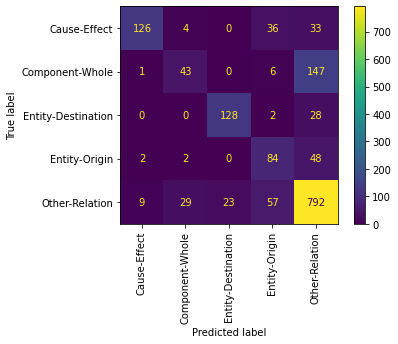

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rounded_labels=np.argmax(y_test, axis=1)

def plotCM(predictions, rounded_labels):
  cm = confusion_matrix(rounded_labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=transformedLables)
  disp.plot(xticks_rotation=90)
  plt.show()



plotCM(predictions, rounded_labels)




In [ ]:
rounded_labels=np.argmax(y_test, axis=1)
print(len(y_test))
print(len(rounded_labels))

1600
1600


In [ ]:
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.913     0.633     0.748       199
           1      0.551     0.218     0.313       197
           2      0.848     0.810     0.828       158
           3      0.454     0.618     0.523       136
           4      0.756     0.870     0.809       910

    accuracy                          0.733      1600
   macro avg      0.704     0.630     0.644      1600
weighted avg      0.734     0.733     0.718      1600



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

testData = load_corpus('/content/drive/My Drive/TEST_FILE_FULL.TXT')
filteredData = replaceRelations(testData)
noComment = removeComments(filteredData)
datasetStats(filteredData, noComment)
jk = cleanComments(filteredData)
lines = cleanSentences(noComment)
sentences = removeTokens(lines)
words, firstToken, secondToken = get_relative_position(sentences, maxSentenceLength)
df = createDF(jk, words, firstToken, secondToken)
df.head()


8003	"The school <e1>master</e1> teaches the lesson with a <e2>stick</e2>."

Other-Relation(e2,e1)

Comment:



Dataset Statistics
Total sentences 2717
Other-Relation -  1527 (56.20%)
Cause-Effect -  328 (12.07%)
Component-Whole -  312 (11.48%)
Entity-Destination -  292 (10.75%)
Entity-Origin -  258 (9.50%)


,sentences,labels,firstToken,secondToken
0,"""The most common audits were about waste and r...",Other-Relation,"[495, 496, 497, 498, 499, 500, 501, 502, 503]","[492, 493, 494, 495, 496, 497, 498, 499, 500]"
1,"""The company fabricates plastic chairs.""",Other-Relation,"[497, 498, 499, 500, 501]","[494, 495, 496, 497, 498]"
2,"""The school master teaches the lesson with sti...",Other-Relation,"[496, 497, 498, 499, 500, 501, 502, 503]","[491, 492, 493, 494, 495, 496, 497, 498]"
3,"""The suspect dumped the dead body into local r...",Entity-Destination,"[493, 494, 495, 496, 497, 498, 499, 500, 501]","[490, 491, 492, 493, 494, 495, 496, 497, 498]"
4,"""Avian influenza is an infectious disease of b...",Cause-Effect,"[497, 498, 499, 500, 501, 502, 503, 504, 505, ...","[483, 484, 485, 486, 487, 488, 489, 490, 491, ..."


In [ ]:
maxSentenceLength = 498

seqs = getSequences(trainedTokenizer, words)
X_seq = padX(seqs)
X_pos1 = pad_sequences(firstToken, maxlen=maxSentenceLength)
X_pos2 = pad_sequences(secondToken, maxlen=maxSentenceLength)

len(X_seq)



Found 19150 unique tokens.


2717

In [ ]:
prediction_probas_test = model.predict([X_seq, X_pos1, X_pos2])

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
              precision    recall  f1-score   support

           0      0.763     0.805     0.783       328
           1      0.431     0.442     0.437       312
           2      0.828     0.709     0.764       292
           3      0.574     0.589     0.581       258
           4      0.783     0.788     0.786      1527

    accuracy                          0.723      2717
   macro avg      0.676     0.667     0.670      2717
weighted avg      0.725     0.723     0.723      2717



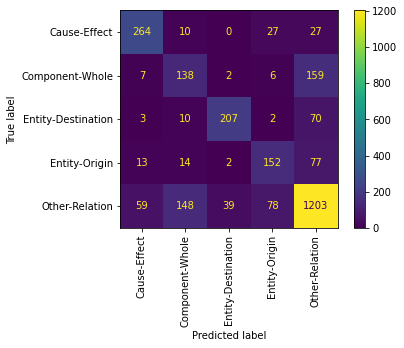

In [ ]:
labels = encodeLables(df)
print(labels)
rounded_labels_test=np.argmax(labels, axis=1)
predictions_test = [np.argmax(pred) for pred in prediction_probas_test]
print(classification_report(rounded_labels_test, predictions_test, digits=3))
plotCM(predictions_test, rounded_labels_test)

In [ ]:

# testSentence = "Then, the target PET <eO>bottle was put inside of a metal <eT>container, which was grounded."

sentences = df['sentences'][0:50].tolist()
labs = df['labels'][0:50].tolist()
firstToken = firstToken[0:50]
secondToken = secondToken[0:50]
maxSentenceLength = 498
seqs = getSequences(trainedTokenizer, sentences)
X_seq_test = padX(seqs)
X_pos1_test = pad_sequences(firstToken, maxlen=maxSentenceLength)
X_pos2_test = pad_sequences(secondToken, maxlen=maxSentenceLength)
predictions_testing = model.predict([X_seq_test, X_pos1_test, X_pos2_test])
preds_testing = [np.argmax(pred) for pred in predictions_testing]




Found 19150 unique tokens.


In [ ]:
correct = 0
wrong = 0
for sent, pred, lab in zip(sentences, preds_testing, labs):
  print("Sentence:", sent)
  print("Prediction:", pred, transformedLables[pred])
  print("Actual:", lab)
  if transformedLables[pred] == lab:
    print("CORRECT")
    correct+=1
  else:
    print("WRONG")
    wrong+=1
print("Total correct", correct)
print("Total wrong", wrong)

Sentence: "The most common audits were about waste and recycling."
Prediction: 4 Other-Relation
Actual: Other-Relation
CORRECT
Sentence: "The company fabricates plastic chairs."
Prediction: 1 Component-Whole
Actual: Other-Relation
WRONG
Sentence: "The school master teaches the lesson with stick."
Prediction: 4 Other-Relation
Actual: Other-Relation
CORRECT
Sentence: "The suspect dumped the dead body into local reservoir."
Prediction: 2 Entity-Destination
Actual: Entity-Destination
CORRECT
Sentence: "Avian influenza is an infectious disease of birds caused by type strains of the influenza virus."
Prediction: 0 Cause-Effect
Actual: Cause-Effect
CORRECT
Sentence: "The ear of the African elephant is significantly larger--measuring cm by cm in the bush elephant."
Prediction: 1 Component-Whole
Actual: Component-Whole
CORRECT
Sentence: "A child is told lie for several years by their parents before he/she realizes that Santa Claus does not exist."
Prediction: 4 Other-Relation
Actual: Other-Rela

In [ ]:
testSentences = ["The <e1>monitor</e1> comprises the display device, <e2>circuitry</e2>, and an enclosure.",
                 "The joey is blind at birth, and must instinctively ascend their <e1>mother</e1>'s <e2>belly</e2> and crawl into the nurturing pouch."]
testLabels = ["Cause-Effect", "Other-Relation"]
formattedSentences = cleanSentences(testSentences)
maxSentenceLength = 498
lines = removeTokens(formattedSentences)
words, firstToken, secondToken = get_relative_position(lines, maxSentenceLength)

seqs = getSequences(trainedTokenizer, words)
X_seq_demo = padX(seqs)
X_pos1_demo = pad_sequences(firstToken, maxlen=maxSentenceLength)
X_pos2_demo = pad_sequences(secondToken, maxlen=maxSentenceLength)


predictions_demo = model.predict([X_seq_demo, X_pos1_demo, X_pos2_demo])
preds_demo = [np.argmax(pred) for pred in predictions_demo]


correct = 0
wrong = 0
for sent, pred, lab in zip(formattedSentences, preds_demo, testLabels):
  print("Sentence:", sent)
  print("Prediction:", pred, transformedLables[pred])
#   # print("Actual:", lab)
#   if transformedLables[pred] == lab:
#     print("CORRECT")
#     correct+=1
#   else:
#     print("WRONG")
#     wrong+=1
# print("Total correct", correct)
# print("Total wrong", wrong)



Found 19150 unique tokens.
Sentence: The <e1>monitor</e1> comprises the display device, <e2>circuitry</e2>, and an enclosure.
Prediction: 1 Component-Whole
Sentence: The joey is blind at birth, and must instinctively ascend their <e1>mother</e1>'s <e2>belly</e2> and crawl into the nurturing pouch.
Prediction: 1 Component-Whole
